In [2]:
import numpy as np 
import random as rand
import seaborn as sb
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# for exact solver
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
# importing images
from IPython.display import Image

In [3]:
# Display style: centered
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;}
</style>
"""))

In [4]:
# default colors for plots 
import matplotlib as mpl
c = ["#63ace5","#4b86b4","#5971AD","#3366ff","#bbeeff","#0000CD",
     "#26466D","#B0C4DE","#05B8CC","#B0E0E6","#7A8B8B","#C1CDCD"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=c) 

# (Inverse) Optimal Transport

<font color='darkblue'> This notebook is broken down into the following sections:

1. Exact solver for OT
2. Sinkhorn Algorithm for OT
3. Inverse OT 
    * General Cost Matrix
    * Graph-based Cost Matrix
4. Simulated annealing
</font>

# 1. Exact Solver for the OT problem

For this we use the toolbox from: 
*Rémi Flamary and Nicolas Courty, POT Python Optimal Transport library,
Website: https://pythonot.github.io/, 2017*

After this section, all algorithms are self-implemented.

In [4]:
# This first example is taken from 
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=10)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()

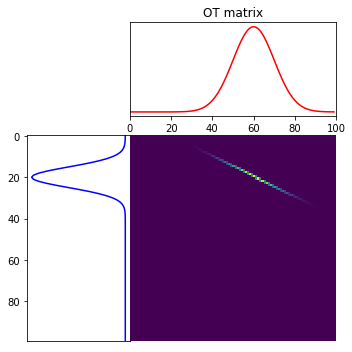

In [5]:
# Solve exact OT problem
G0 = ot.emd(a, b, M)

plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, G0, 'OT matrix')

***
# 2. Sinkhorn Algorithm for the OT Problem: Discrete Measures in $\mathbb{R}$

Here we first implement for the algorithm for discrete measures in $\mathbb{R}$. 

For the cost we consider the metric of distance $c(x,y) = |x-y|^2$. 

The section is broken down as follows:
* 2.1 Discretising Gaussian measures
* 2.2 Sinkhorn's algorithm
* 2.3 Evolution of the transportation plan with respect to $\epsilon$
* 2.4 Convergence rate with respect to $\epsilon$
* 2.5 What is the numerical boundary of the algorithm?

### 2.1 Discretising Gaussian measures

In [5]:
def create_interval(g1,g2):
    """ Set a grid for measures, based on largest 97% interval of the measures """
    (u1,s1,u2,s2) = g1
    (u3,s3,u4,s4) = g2
    all_ints = [norm.interval(0.97,loc=u1,scale=s1),norm.interval(0.97,loc=u2,scale=s2),
                norm.interval(0.97,loc=u3,scale=s3),norm.interval(0.97,loc=u4,scale=s4)]
    mins = [x[0] for x in all_ints]
    maxs = [x[1] for x in all_ints]
    return (min(mins),max(maxs))

def gauss_lincomb(g,grid,n=100):
    """ Returns a normalised discretized vector of the sum of 2 gaussians
        given by g=(u1,s1,u2,s2) over a given grid
        * For a single Gaussian: set u2=u1,s2=s1 """
    u1,s1,u2,s2 = g
    width = abs(grid[1]-grid[0])/n
    vect1 = norm.pdf(grid,u1,s1)*width
    vect2 = norm.pdf(grid,u2,s2)*width
    vect = (vect1+vect2)/np.sum(vect1+vect2)
    return vect.reshape(len(vect),1)
    
def two_gaussians(g1,g2,n=100):
    """ Returns 2 vectors, each a discretized sum of 2 gaussians
        and a vector of their interval """
    interval = create_interval(g1,g2)
    grid = np.linspace(interval[0],interval[1],n)  
    vect1,vect2 = gauss_lincomb(g1,grid),gauss_lincomb(g2,grid)
    return grid,vect1,vect2

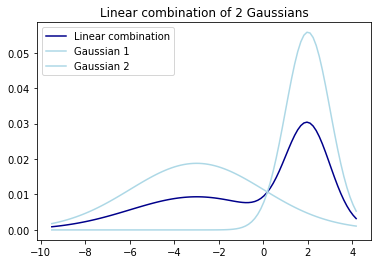

In [6]:
# Visualise these measures
x,v1,v2 = two_gaussians((0,1,0,1),(2,1,-3,3),100)
g1 = gauss_lincomb((2,1,2,1),x)
g2 = gauss_lincomb((-3,3,-3,3),x)
plt.plot(x,v2,label="Linear combination",color="darkblue")
plt.plot(x,g1,label="Gaussian 1",color="lightblue")
plt.plot(x,g2,label="Gaussian 2",color="lightblue")
plt.legend()
plt.title("Linear combination of 2 Gaussians")
plt.show()

### 2.2 Sinkhorn's algorithm
Here we implement Sinkhorn's algorithm, given a specific $\epsilon = $ `eps`, two measures `a` and `b` and their locations `bins_a` and `bins_b`.
Their convergence is controlled by $||\mathbf{P}^{(l)}\mathbf{1}_m - \mathbf{a}||_1$ and $||\mathbf{P}^{(l)T}\mathbf{1}_n - \mathbf{b}||_1$ as in **Remark 4.14** of *Computational Optimal Transport*.

In [7]:
def distance_matrix(bins_a,bins_b):
    def distance(x,y): return abs(x-y)
    return np.array([[distance(x,y) for x in bins_b] for y in bins_a])

In [8]:
def sinkhorn(eps,a,b,bins_a=None,bins_b=None,bound=0.001,C=None,return_bounds=False):
    def cost(P,C): return np.trace(C.T @ P)        # Frobenius inner product
    def P(u,v): return np.diag(u.reshape(len(u),)) @ K @ np.diag(v.reshape(len(v),))
    if C is None: 
        if bins_a is None or bins_b is None: 
            print("Cannot compute cost")
            return
        else: C = distance_matrix(bins_a,bins_b)   # create cost matrix if none inputted 
    K = np.exp((-np.divide(C,eps)))                # create K matrix (Gibbs kernel)
    v = np.ones((len(b),1))
    cont = True
    iters = 0
    bounds = []
    while cont:
        iters+=1
        u = a/(K@v)
        v = b/(K.T @ u)
        bound1 = P(u,v) @ np.ones((len(v),1)) - a
        bound2 = P(u,v).T @ np.ones((len(u),1)) - b
        bound1,bound2 = np.linalg.norm(bound1,1),np.linalg.norm(bound2,1)
        if  bound1 < bound and bound2 < bound: cont=False
        if return_bounds: bounds.append((bound1,bound2))
    P1 = P(u,v)
    if return_bounds: return P1,cost(P1,C),iters,bounds
    return P1,cost(P1,C),iters

### 2.3 Evolution of the transportation plan with respect to $\epsilon$

As $\epsilon \rightarrow 0$, we have that the plan gets closer to the optimal transport plan and as this happens, the plan also becomes more sparse. Equivalently, as $\epsilon$ increases, the couplings tend to spread more. We also see that as $\epsilon$ decreases, more iterations are required to reach convergence.

In [9]:
def plot_transport(a,b,bins,title="$a$ will be transported to $b$",xticks=None):
    """ Plot a and b (a to be transported to b) """
    fig, ax = plt.subplots()
    ax.plot(bins,a,label="$a$",color="lightblue")
    ax.plot(bins,b,label="$b$",color="darkblue")
    ax.legend()
    if xticks is not None: ax.set_xticklabels(xticks)
    ax.set_title(title)
    return plt

def plot_evolution(a,b,bins,e=[10,1.5,0.4,0.02],bound=0.001,C=None):
    """ Plot the evolution of the transport plan of a to b for different eps given in e"""
    n_e = len(e)
    plt.figure(figsize=(n_e*10,15))
    for i in range(n_e):
        eps = e[i]
        plt.subplot(1,n_e,i+1) # first heatmap
        P_star,cost,iters = sinkhorn(eps,a,b,bins,bins,bound,C=C)
        ax = sns.heatmap(P_star,cbar=False,cmap="Blues",square= True) #Blues,Greys
        ax.tick_params(left=False,bottom=False,labelbottom=False,labelleft=False) # removes the dashes then labels
        ax.set_title("$\epsilon$="+str(e[i])+"\n (cost="+str(round(cost,4))+", iters="+str(iters)+")",fontsize=30)
        ax.set_xlabel("$b$",fontsize = 25)
        ax.set_ylabel("$a$",fontsize = 25)
    plt.show()

**Test case: Identical Normal Gaussians**

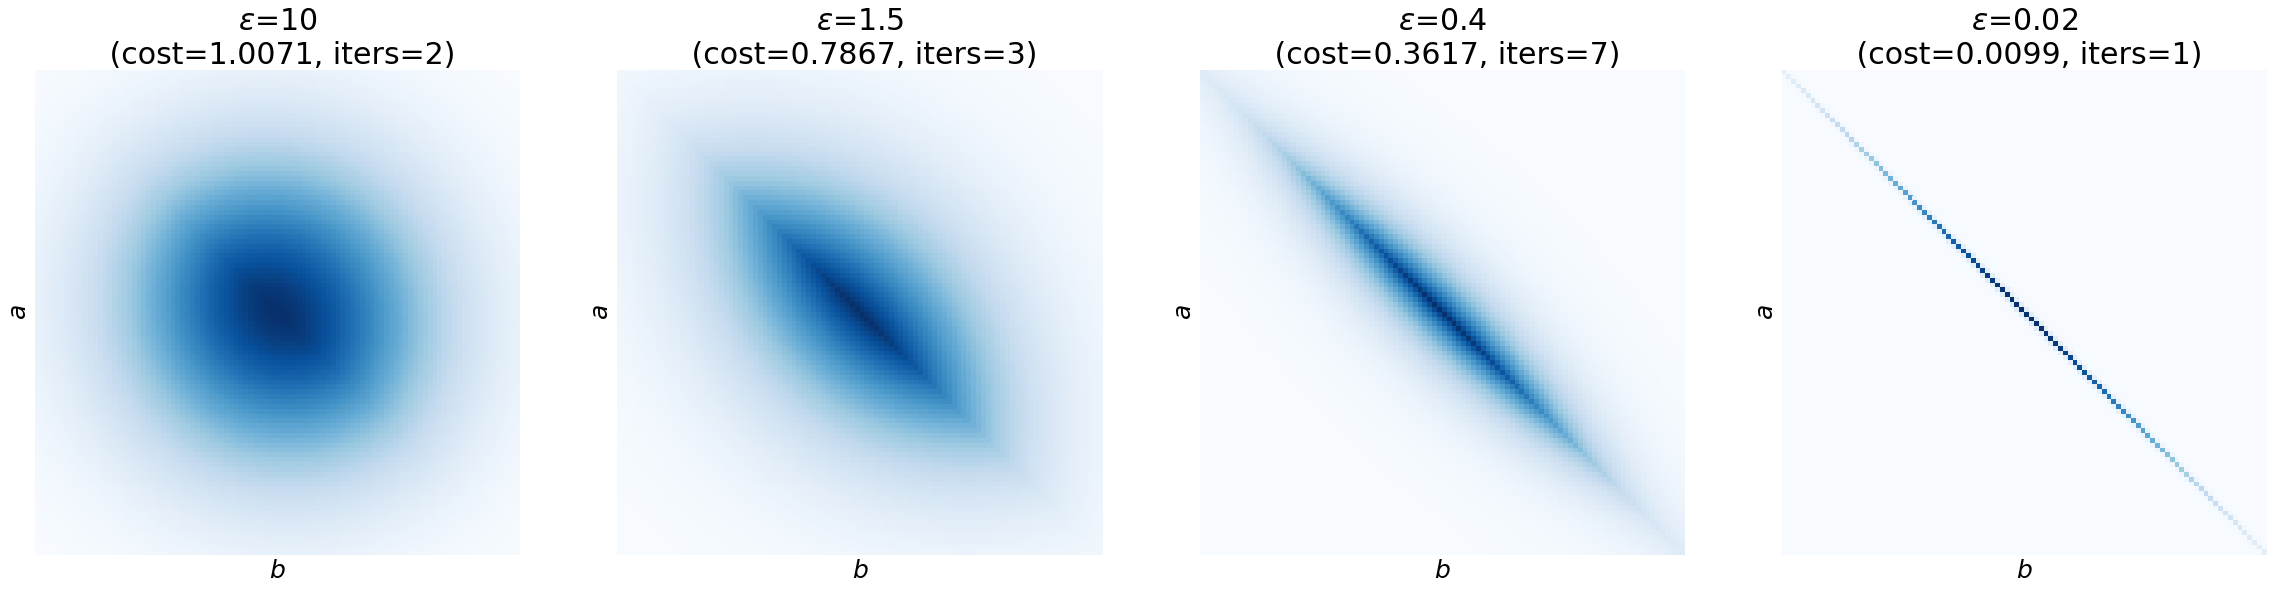

In [12]:
# Two normal Gaussians
x_test,a_test,b_test = two_gaussians((0,1,0,1),(0,1,0,1))
# Plot the transport plan for different eps
plot_evolution(a_test,b_test,x_test)

**Unidentical measures**

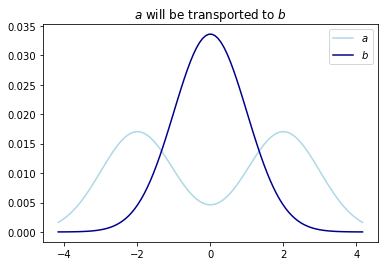

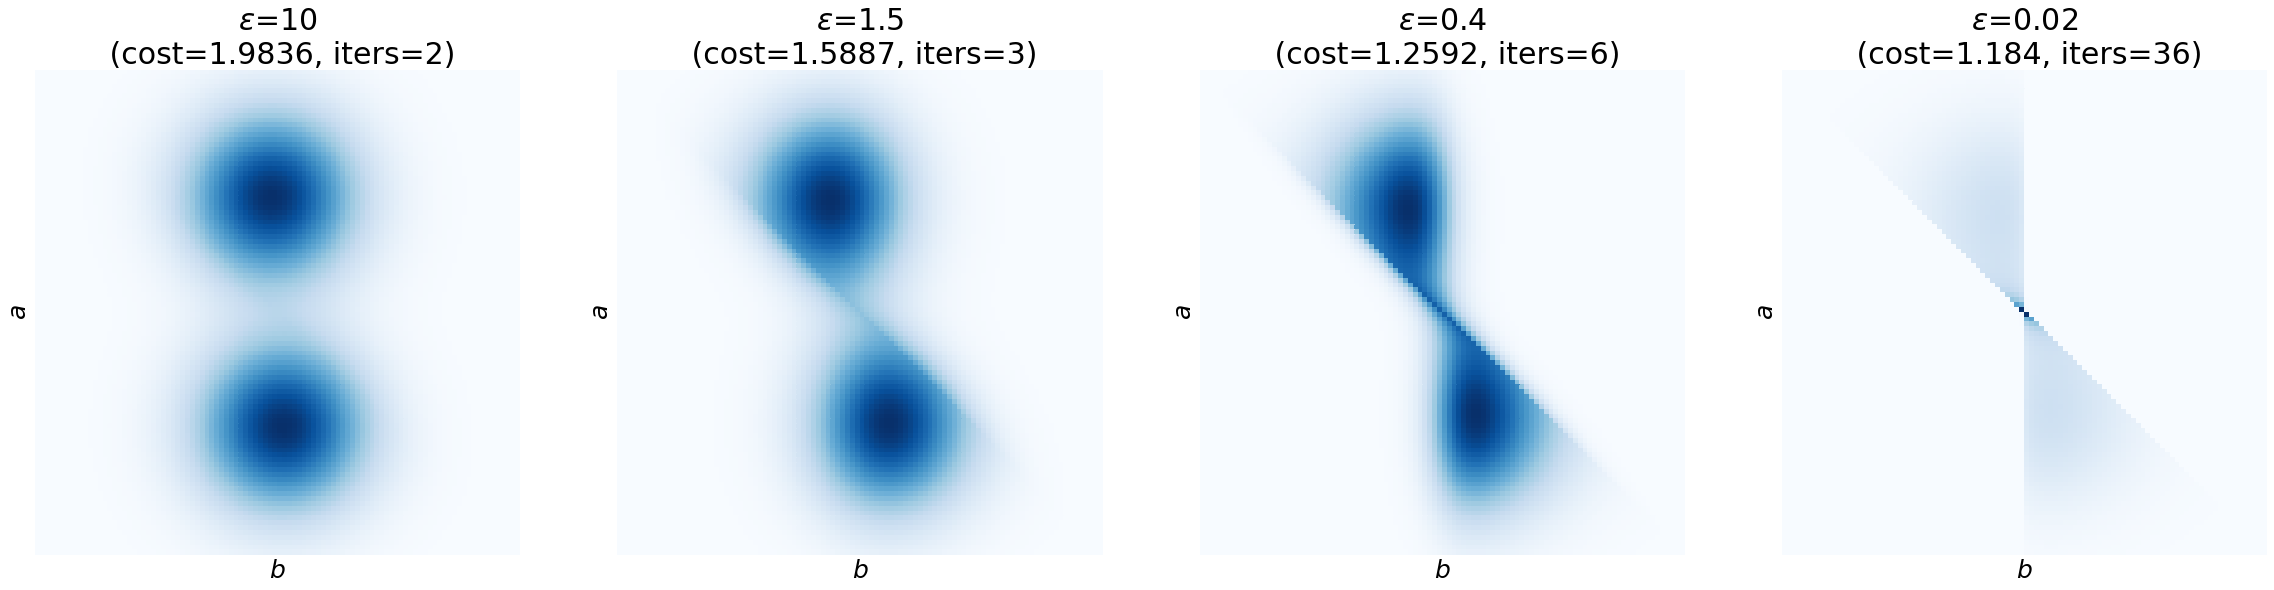

In [206]:
x,a,b = two_gaussians((-2,1,2,1),(0,1,0,1))
plt = plot_transport(a,b,x)
plot_evolution(a,b,x)

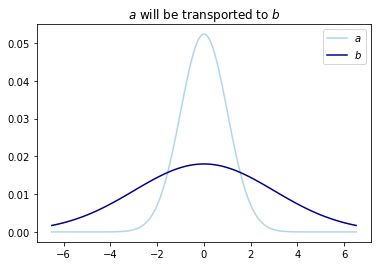

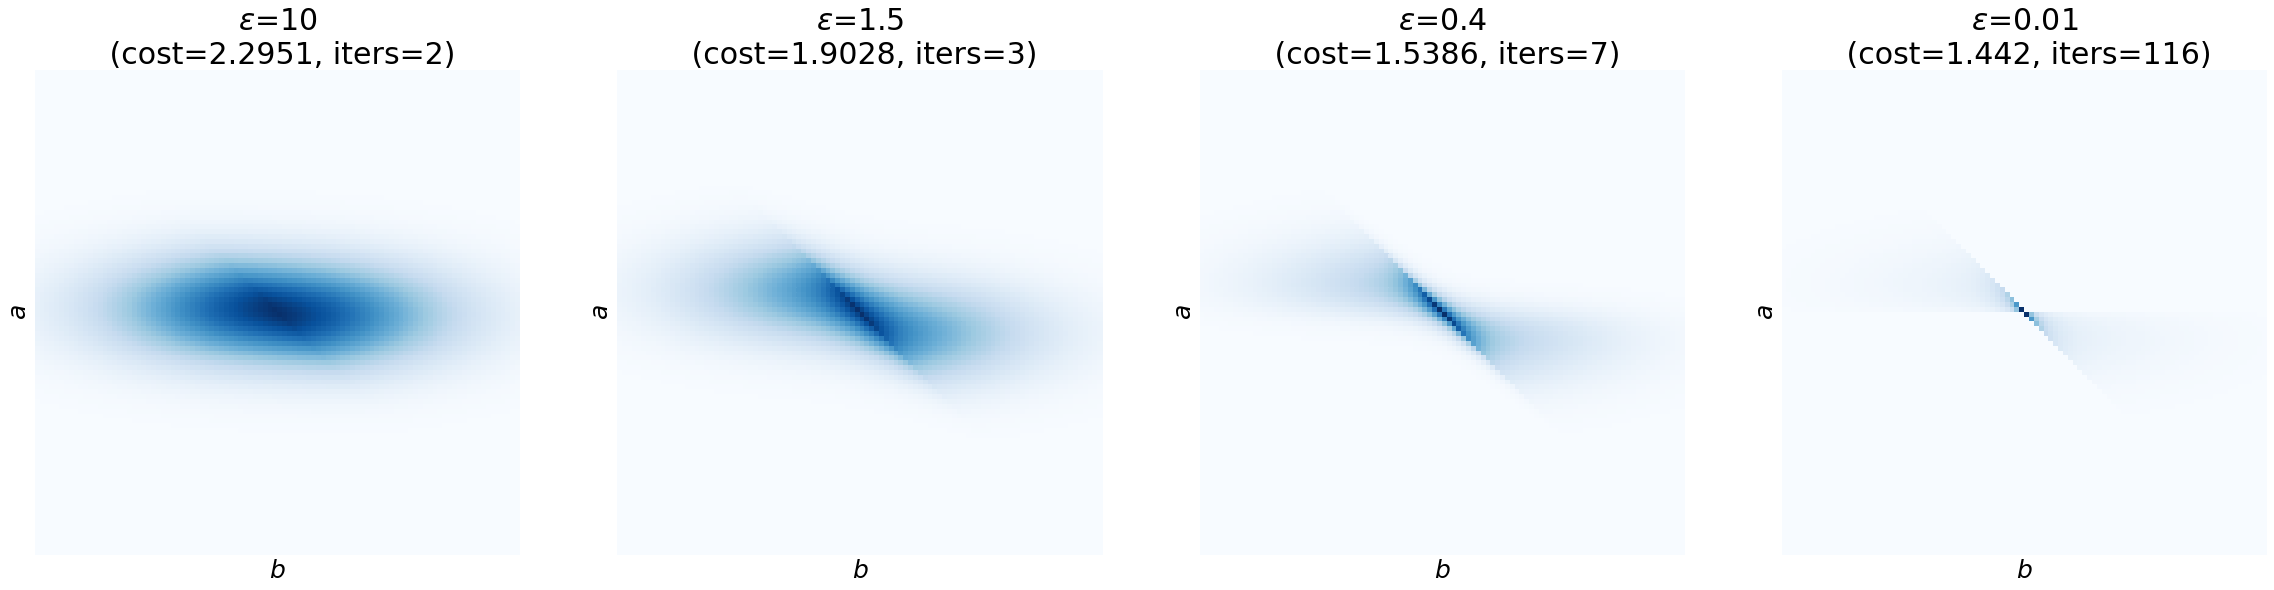

In [12]:
x2,a2,b2 = two_gaussians((0,1,0,1),(0,3,0,3))
plt2 = plot_transport(a2,b2,x2)
plot_evolution(a2,b2,x2,e=[10,1.5,0.4,0.01])

### 2.4 Convergence rate with respect to $\epsilon$

Here we explicitly see the convergence rate depending on $\epsilon$ by plotting the value of the bound $||\mathbf{P}^{(l)}\mathbf{1}_m - \mathbf{a}||_1$ vs the number of iterations. We see that smaller values of $\epsilon$ require longer time to reach convergence.

In [11]:
def plt_convergence_rates(a,b,bins,e=[10,1,0.1,0.02,0.01],bound=0.001):
    n_e = len(e)
    plt.figure()
    for i in range(n_e):
        eps = e[i]
        P_star,cost,iters,bounds = sinkhorn(eps,a,b,bins,bins,bound,return_bounds=True)
        plt.plot([b[0] for b in bounds],label="$\epsilon =$"+str(eps))
    plt.title("Visualisation for the rate of convergence of the \n Sinkhorn algorithm for different $\epsilon$")
    plt.xlabel("Iterations")
    plt.ylabel("Value of $||\mathbf{P}^{(l)}\mathbf{1}_m - \mathbf{a}||_1$")
    plt.legend()
    plt.show()

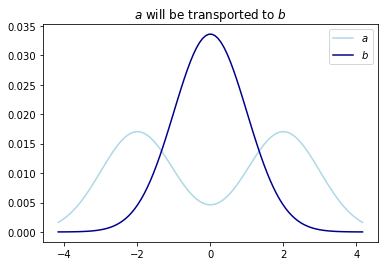

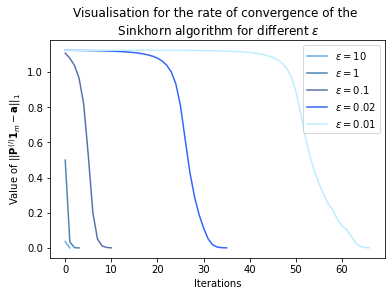

In [280]:
x,a,b = two_gaussians((-2,1,2,1),(0,1,0,1))
plt = plot_transport(a,b,x)
plt_convergence_rates(a,b,x)

### 2.5 What is the numerical boundary of the algorithm?

In [14]:
def test_epsilons(transport,labels=None,bound=0.001):
    """ Plot the evolution of the transport plan of a to b for different eps given in e"""
    
    # Test epsilons
    warnings.simplefilter('error', RuntimeWarning)
    failed_at = []
    for bins,a,b in transport:
        eps = 0.04
        cont = True
        while cont and eps>0:
            try: 
                P_star,cost,iters = sinkhorn(eps,a,b,bins,bins,bound)
                eps -= 0.004
            except:
                failed_at.append(eps)
                break
        if eps==0: failed_at.append(0)
    warnings.simplefilter('default', RuntimeWarning)
            
    # Create table
    if labels == None: labels = ["Gaussian {}".format(i) for i in range(len(transport))]
    fig, ax = plt.subplots(figsize=(3*len(transport),0.7))
    ax.axis('off')
    rcolors,ccolors = plt.cm.BuPu(np.full(1, 0.1)),plt.cm.BuPu(np.full(len(labels), 0.1))
    table = ax.table(cellText = [failed_at], colLabels=labels, 
        colColours =ccolors, cellLoc ='center',loc='bottom') 
    table.scale(1, 2)
    table.set_fontsize(12)
    plt.suptitle("$\epsilon$ at which the Sinkhorn algorithm encounters numerical issues for different problems")
    plt.show()   
    
    # Visualise the input problem
    fig, ax = plt.subplots(figsize=(3*len(transport),2))
    for i,(x,a,b) in enumerate(transport):
        plt.subplot(1,len(transport),i+1)
        ax = plot_transport(a,b,x)
        ax.title("")
        ax.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
    plt.show()  

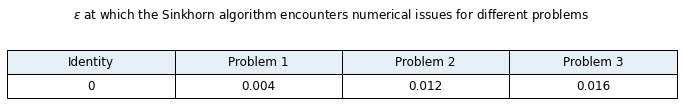

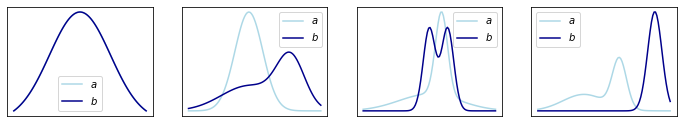

In [47]:
transport = [two_gaussians((0,1,0,1),(0,1,0,1)),two_gaussians((0,1,0,1),(0,2,3,1)),
             two_gaussians((0,5,2,1),(0,1,3,1)),two_gaussians((-10,3,-5,1),(0,1,0,1))]
labels = ['Identity', 'Problem 1', 'Problem 2', 'Problem 3']
test_epsilons(transport,labels)

We see that for simple transport plans (identity, small changes, etc) we can set the $\epsilon$ to be very small, but as soon as the distance/cost becomes much greater, the smallest $\epsilon$ possible becomes somewhat larger. This, however, does vary with the given $a$ and $b$.

***
# 3. Implementation of *Inverse Optimal Transport*
Paper by ANDREW M. STUART AND MARIE-THERESE WOLFRAM

Here we implement the solving of the inverse OT problem using Random Walk Metropolis within Gibbs to sample from the posterior distribution of the desired variables $a,b$ and $C$: the cost of transportation and the initial distributions. 

#### Migration flow example

In [13]:
# The statistics: the number of people reported 'received'
# data from : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2967706/table/Tab2/?report=objectonly
countries = ["CZ",  "DE",  "DK",  "LU", "NL",  "PL"]
tmap_mig = [[0,     9218,  262,   4,    511,   45  ], # CZ
            [1363,  0,     4001,  454,  9182,  2876], # DE
            [46,    2687,  0,     11,   475,   34, ], # DK
            [2,     2282,  162,   0,    161,   5   ], # LU
            [255,   13681, 864,   27,   0,     163 ], # NL
            [1608,  136927,2436,  19,   5744,  0   ]] # PL
tmap_mig = tmap_mig/np.sum(tmap_mig)
sigma_mig = 0.04
variance_mig = [0.04,0.04,0.1]

In [14]:
cost_init_mig = np.ones(tmap_mig.shape)
for i in range(len(cost_init_mig)):
    for j in range(len(cost_init_mig[0])):
        if i==j: cost_init_mig[i][j] = 10   # penalise not moving
        else: cost_init_mig[i][j] = max(0,rand.gauss(0.5,sigma_mig))

## 3.1 Implementation of RwM-within-Gibbs for a general cost matrix

In [133]:
def psi(X,sigma,T,exact=False):
    a,b,W = X
    if exact: plan = ot.emd(a, b, W/np.sum(W))
    else: plan,cost,iters = sinkhorn(0.04,a/np.sum(a),b/np.sum(b),C=W/np.sum(W))
    return (1/(2*sigma**2)) * (np.linalg.norm(T - plan))**2

def accep(X,Y,T,sigma,exact=False):
    """give acceptance probability"""
    diff = np.exp(psi(X,sigma,T) - psi(Y,sigma,T))
    return min(1,diff)

def walk(sigma,T,i,terms,variance,exact=False):
    """ perform random walk and accept or reject the proposed change
        returns: a,(u,v,W) where a = 0 or 1, accepted or not and (u,v,W) are the new terms
        """
    walk = np.random.normal(0,variance[i],terms[i].shape)   # random walk
    if not (terms[i]+walk > 0).all(): # check proposal is > 0 entrywise
        return 0,tuple(terms)      
    # propose new terms
    new_terms = [terms[j]+walk if j==i else terms[j] for j in range(3)]
    
    # get accep rate
    a_rate = accep(tuple(terms),tuple(new_terms),T,sigma)   
        
    if rand.uniform(0,1) <= a_rate: # accept or reject
        return 1,tuple(new_terms) 
    else: 
        
        return 0,tuple(terms)
    
def rand_walk_metrop(sigma,T,variance,n=1000,exact=False,memory=False,cost=False,W_init=None):
    """ Perform RwM until convergence
        Input: sigma    - the estimated noise of the given plan
               T        - the given transport plan
               variance - given as [v1,v2,v3] the variance of the steps taken for u,v,W during RwM 
               exact    - a Boolean, solve with exact transport plan (otherwise Sinkhorn)
               memory   - keep track of the whole path followed and return this at the end
               cost     - keep track of the cost of the plans produced and return this at the end
               W_init   - optional starting value for W """
    
    # initialise u,v,W as uniform
    u,v = np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1)),np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1))
    if W_init is None: W = np.array([[1/len(T)**2 for _ in range(len(T))] for _ in range(len(T))])
    else: W = W_init
    
    # random walk
    order = [0,1,2]
    path = []
    costs = []
    accep_rates = [0,0,0]
    for index in range(n):
        if index%10000==0:print(str(index)+"_")
        rand.shuffle(order) # randomise choice of component to change
        for i in order:
            a,(u,v,W) = walk(sigma,T,i,[u,v,W],variance) 
            accep_rates[i] += a
        path.append((u/np.sum(u),v/np.sum(v),W/np.sum(W)))
        if cost: 
            plan,c,iters = sinkhorn(0.1,u/np.sum(u),v/np.sum(v),C=W/np.sum(W))
            costs.append(c)
    if memory and cost: return path,costs,np.divide(accep_rates,n)
    elif memory: return path
    elif cost:   return path[-1],costs
    else:        return path[-1]


#### Functions for plotting

In [10]:
def running_average(path):
    """ Returns the running averages of u,v,W """
    u_averages = [path[0][0]]
    v_averages = [path[0][1]]
    w_averages = [path[0][2]]
    for i in range(1,len(path)):
        u_averages.append((u_averages[-1]*(i) + path[i][0])/(i+1))
        v_averages.append((v_averages[-1]*(i) + path[i][1])/(i+1))
        w_averages.append((w_averages[-1]*(i) + path[i][2])/(i+1))
    return u_averages,v_averages,w_averages

In [11]:
def plot_inverse_transport(path,costs,accep_rates,averages,
                           convergence=False,
                           labels=None,
                           transport=(False,None)):
    """ 
    Plot results of solving the inverse optimal transport problem
    ------------------------------------------------------------------------------
    INPUT:
    * paths,costs,accep_rates -> what is returned by the inverse optimal problem 
                                 (rand_walk_metrop)
    ------------------------------------------------------------------------------
    OPTIONAL ARGUMENTS:
    * convergence -> look at how the values of u,v,W change with n 
                     (plots the running average of the individual vector entries)
    * labels      -> what the tick values should be labelled if not automatically numerically labeled
                     (can be used in conjunction with transport)
    * transport   -> plots the original transport map and the transport map given the solved components
                     given as transport = (True,t_map) where t_map is the original transport map 
    ------------------------------------------------------------------------------ """
    
    u_averages,v_averages,w_averages = averages
    u,v,W = u_averages[-1],v_averages[-1],w_averages[-1]  
    comp = ["u","v","W"]
    
    if convergence:
        X = [i for i in range(len(path))]
        plt.figure(figsize=(20,5))
        for i in range(3):
            plt.subplot(1,3,i+1)
            N = len(path[-1][i])
            for j in range(N):
                if i==0: plt.plot([u[j] for u in u_averages],label="$u_"+str(j)+"$")
                if i==1: plt.plot([v[j] for v in v_averages],label="$v_"+str(j)+"$")
                if i==2: plt.plot([w[j][0] for w in w_averages],label="$W_{"+str(j)+",0}$")
            if i==2: plt.title("Running average of the components of the first column of W")
            else:    plt.title("Running average of the components of $"+comp[i]+"$")
            plt.xlabel("Iterations")
            plt.ylabel("Value")
            plt.legend()
        plt.plot()
        
    if transport[0]:
        tmap = transport[1]
        n = len(W_av[-1])
        plan,cost,iters = sinkhorn(0.04,u,v,C=W)

        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1) # first heatmap
        ax = sns.heatmap(tmap,cbar=False,cmap="Blues",square= True) #Blues,Greys
        ax.tick_params(left=False,bottom=False)
        if labels is not None: ax.set_xticklabels(labels)
        if labels is not None: ax.set_yticklabels(labels)
        ax.set_title("Initial transport plan",fontsize=13)
        
        plt.subplot(1,2,2) # second heatmap
        ax = sns.heatmap(plan,cbar=False,cmap="Blues",square= True) 
        ax.tick_params(left=False,bottom=False) 
        if labels is not None: ax.set_xticklabels(labels)
        if labels is not None: ax.set_yticklabels(labels)
        ax.set_title("Transport plan given the \n solved components",fontsize=13)
        
        plt.plot()      

In [12]:
def plot_posteriors(components,path):
        """ look at the posterior distribution of u,v or W
            components given as a dictionary 
            e.g. {0:[1,2,3],2:[2,3,4]} will plot the distributions of u_1,u_2,u_3 and W_2,W_3,W_4"""
        comp = ["u","v","W"]
        for component in components.keys():
            plt.figure(figsize = (5,5))
            if component==2: # if W is called for, we plot the first column of the cost matrix
                for i in components[component]:
                    sb.kdeplot([float(p[component][i][0]) for p in path[len(path)//2:]],
                               label="$W_{"+str(i)+",0}$",shade=True)
            else: 
                for i in components[component]:
                    sb.kdeplot([float(p[component][i]) for p in path[len(path)//2:]],
                               label="$"+comp[component]+"_"+str(i)+"$",shade=True)
            plt.title("Posterior for the components of "+comp[component])
            plt.plot()    

### Implementation of RwM using 500000 iterations on a general cost matrix

In [169]:
path_mig,costs_mig,accep_mig = rand_walk_metrop(sigma_mig,tmap_mig,variance_mig,n=500000,exact=False,
                                                memory=True,cost=True,W_init=cost_init_mig)

0_
10000_
20000_
30000_
40000_
50000_
60000_
70000_
80000_
90000_
100000_
110000_
120000_
130000_
140000_
150000_
160000_
170000_
180000_
190000_
200000_
210000_
220000_
230000_
240000_
250000_
260000_
270000_
280000_
290000_
300000_
310000_
320000_
330000_
340000_
350000_
360000_
370000_
380000_
390000_
400000_
410000_
420000_
430000_
440000_
450000_
460000_
470000_
480000_
490000_


In [219]:
u_av,v_av,W_av = running_average(path_mig)

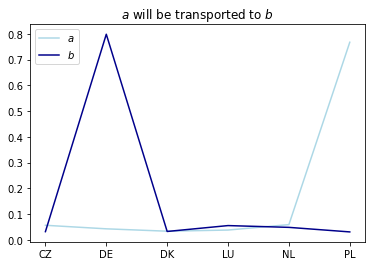

In [220]:
x_mig,u_mig,v_mig = range(6),u_av[-1],v_av[-1]
plt2 = plot_transport(u_mig,v_mig,x_mig,xticks=[""]+countries)

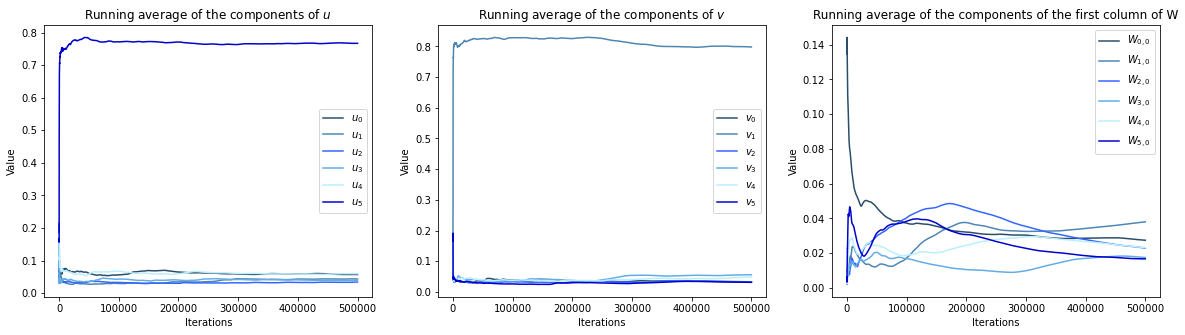

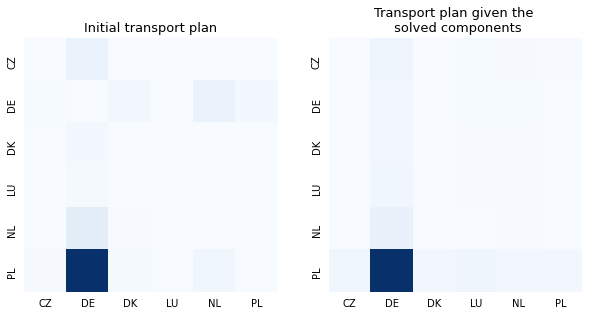

In [243]:
plot_inverse_transport(path_mig,costs_mig,accep_mig,(u_av,v_av,W_av),
                           convergence=True,
                           labels=countries,
                           transport=(True,tmap_mig))

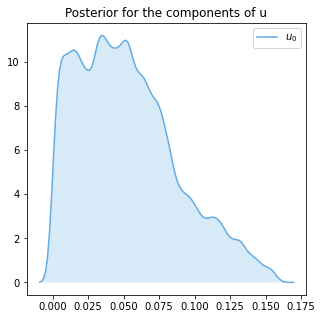

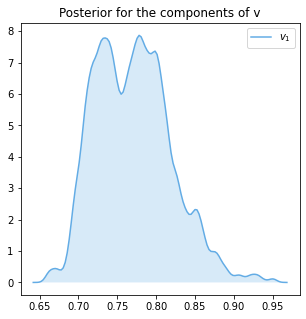

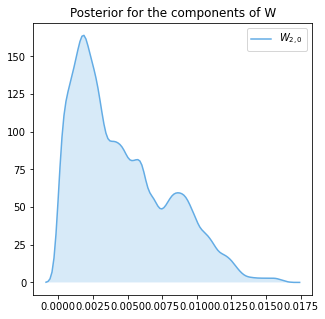

In [287]:
plot_posteriors({0:[0],1:[1],2:[2]},path_mig)

## 3.2 RwM-within-Gibbs for a graph based cost

Here we assume that to move from one country to another we have to pass through neighbouring countries. Essentially this considers land travel as opposed to air travel. 

This can be defined by a vector $\mathbf{f}$ which gives the entries of an adjacency matrix which is not neccessarily symmetric. This is illustrated below. This can be inputed to Djisktra's algorithm to compute the cost matrix. 
  
`..........CZ   DE   DK   LU   NL   PL
CZ   A =[[0,   f1,  0,   0,   0,   f2  ], 
DE       [f3,  0,   f4,  f5,  f6,  f7  ], 
DK       [0,   f8,  0,   0,   0,   0   ], 
LU       [0,   f9,  0,   0,   0,   0   ], 
NL       [0,   f10, 0,   0,   0,   0   ], 
PL       [f11, f12, 0,   0,   0,   0   ]]`
     
The RwM-within-Gibbs algorithm remains relatively unchanged, except for that $W$ is replaced by $f$ in the random walk, and the cost is then calculated from this.

#### Functions to get the cost matrix from $\mathbf{f}$

In [15]:
## FUNCTIONS TO CALCULATE COST MATRIX FROM f

def adjacency(f):
    A = np.zeros((6,6))
    A[0][1],A[0][5] = f[0],f[1]
    for i in [0,2,3,4,5]:       
        A[1][i] = f[i+2]
    A[2][1] = f[7]
    A[3][1] = f[8]
    A[4][1] = f[9]
    A[5][0],A[5][1] = f[10],f[11]
    return A

def dijkstra(A):
    """ Return the cost matrix related to the adjacency matrix by running Dijkstra's algorithm"""
    cost_matrix = []
    for node in range(len(A)):
        costs = [float("inf") for _ in range(len(A))] # cost from curr node to other nodes
        visited = [False for _ in range(len(A))]   # node visited or not
        costs[node] = 0   # no cost of moving to self 
        while True: # while we still have nodes to visit
            
            # find node closest to curr node
            # by looking at all unvisited nodes
            lowest_cost = float("inf")
            lowest_index = -1
            for i in range(len(A)):
                if costs[i] < lowest_cost and not visited[i]:
                    lowest_cost = costs[i]
                    lowest_index = i

            if lowest_index == -1: break   # all nodes were visited => finished this node 
            
            for i in range(len(A[lowest_index])):    # for all ngbhs not get visited
                # if the path over this edge is shorter
                if A[lowest_index][i] != 0 and costs[i] > costs[lowest_index] + A[lowest_index][i]: 
                    # get new shortest path
                    costs[i] = costs[lowest_index] + A[lowest_index][i]
            visited[lowest_index] = True # we are done with this node
        cost_matrix.append(costs)
    # set the cost of not moving to be high
    for i in range(6):
        cost_matrix[i][i] = 10
    return np.asarray(cost_matrix)

def cost_from_f(f):
    A = adjacency(f)
    C = dijkstra(A)
    return C

#### RwM adapted to $\mathbf{f}$

In [98]:
## RWM ADAPTED TO f INSTEAD OF W

def psi_f(X,sigma,T,exact=False):
    a,b,f = X
    W = cost_from_f(f)
    if exact: plan = ot.emd(a, b, W/np.sum(W))
    else: plan,cost,iters = sinkhorn(0.04,a/np.sum(a),b/np.sum(b),C=W/np.sum(W))
    return (1/(2*sigma**2)) * (np.linalg.norm(T - plan))**2

def accep_f(X,Y,T,sigma,exact=False):
    """give acceptance probability"""
    return min(1,np.exp(psi_f(X,sigma,T) - psi_f(Y,sigma,T)))

def walk_f(sigma,T,i,terms,variance,exact=False):
    """perform random walk and accept or reject the proposed change"""
    walk = np.random.normal(0,variance[i],terms[i].shape)   # random walk
    if not (terms[i]+walk > 0).all(): 
        return 0,tuple(terms)   # check proposal is > 0 entrywise
    new_terms = [terms[j]+walk if j==i else terms[j] for j in range(3)]
    a_rate = accep_f(tuple(terms),tuple(new_terms),T,sigma)   # get acceptance rate
    if rand.uniform(0,1) <= a_rate: 
        return 1,tuple(new_terms) # accept or reject
    else: return 0,tuple(terms)
    
def rand_walk_metrop_f(sigma,T,variance,n=1000,exact=False,memory=False,f_init=None):
    """ Perform RwM until convergence
        Input: sigma    - the estimated noise of the given plan
               T        - the given transport plan
               variance - given as [v1,v2,v3] the variance of the steps taken for u,v,W during RwM 
               exact    - a Boolean, solve with exact transport plan (otherwise Sinkhorn)
               memory   - keep track of the whole path followed and return this at the end
               cost     - keep track of the cost of the plans produced and return this at the end
               f_init   - optional starting value for f """
    
    # initialise u,v,f as uniform
    u,v = np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1)),np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1))
    if f_init is None: 
        print("UNABLE TO COMPUTE. NEED INITIAL f. ABORT") 
        return
    f = f_init
    
    # random walk
    order = [0,1,2]
    path = []
    costs = []
    accep_rates = [0,0,0]
    for index in range(n):
        if index%10000==0:print(str(index)+"_ ")
        rand.shuffle(order) # randomise choice of component to change
        for i in order:
            a,(u,v,f) = walk_f(sigma,T,i,[u,v,f],variance) 
            accep_rates[i] += a
        path.append((u/np.sum(u),v/np.sum(v),f/np.sum(f)))

    if memory: return path,np.divide(accep_rates,n)
    elif memory: return path
    else:        return path[-1]


#### Plotting adapted to $\mathbf{f}$

In [17]:
## Plotting adapted to f 

def plot_inverse_transport_f(path,accep_rates,averages,
                           convergence=False,
                           labels=None,
                           transport=(False,None)):
    """ 
    Plot results of solving the inverse optimal transport problem
    ------------------------------------------------------------------------------
    INPUT:
    * paths,costs,accep_rates -> what is returned by the inverse optimal problem 
                                 (rand_walk_metrop)
    ------------------------------------------------------------------------------
    OPTIONAL ARGUMENTS:
    * convergence -> look at how the values of u,v,W change with n 
                     (plots the running average of the individual vector entries)
    * labels      -> what the tick values should be labelled if not automatically numerically labeled
                     (can be used in conjunction with transport)
    * transport   -> plots the original transport map and the transport map given the solved components
                     given as transport = (True,t_map) where t_map is the original transport map 
    ------------------------------------------------------------------------------ """
    
    u_averages,v_averages,f_averages = averages
    u,v,f = u_averages[-1],v_averages[-1],f_averages[-1]  
    comp = ["u","v","f"]
    
    if convergence:
        X = [i for i in range(len(path))]
        plt.figure(figsize=(20,5))
        for i in range(3):
            plt.subplot(1,3,i+1)
            N = len(path[-1][i])
            for j in range(N):
                if i==0: plt.plot([u[j] for u in u_averages],label="$u_{"+str(j)+"}$")
                if i==1: plt.plot([v[j] for v in v_averages],label="$v_{"+str(j)+"}$")
                if i==2: plt.plot([f[j] for f in f_averages],label="$f_{"+str(j)+"}$")
            plt.title("Running average of the components of $"+comp[i]+"$")
            plt.xlabel("Iterations")
            plt.ylabel("Value")
            plt.legend()
        plt.plot()
        
    if transport[0]:
        tmap = transport[1]
        #n = len(f_av[-1])
        W = cost_from_f(f)
        plan,cost,iters = sinkhorn(0.04,u,v,C=W)

        plt.figure(figsize=(10,5))
        
        plt.subplot(1,2,1) # first heatmap
        ax = sns.heatmap(tmap,cbar=False,cmap="Blues",square= True) #Blues,Greys
        ax.tick_params(left=False,bottom=False)
        if labels is not None: ax.set_xticklabels(labels)
        if labels is not None: ax.set_yticklabels(labels)
        ax.set_title("Initial transport plan",fontsize=13)
        
        plt.subplot(1,2,2) # second heatmap
        ax = sns.heatmap(plan,cbar=False,cmap="Blues",square= True) 
        ax.tick_params(left=False,bottom=False) 
        if labels is not None: ax.set_xticklabels(labels)
        if labels is not None: ax.set_yticklabels(labels)
        ax.set_title("Transport plan given the \n solved components",fontsize=13)
        
        plt.plot()      
        
        
def plot_posteriors_f(components,path):
        """ look at the posterior distribution of u,v or f
            components given as a dictionary 
            e.g. {0:[1,2,3],2:[2,3,4]} will plot the distributions of u_1,u_2,u_3 and f_2,f_3,f_4"""
        comp = ["u","v","f"]
        for component in components.keys():
            plt.figure(figsize = (5,5))
            for i in components[component]:
                sb.kdeplot([float(p[component][i]) for p in path[len(path)//2:]],
                           label="$"+comp[component]+"_{"+str(i)+"}$",shade=True)
            plt.title("Posterior for the components of "+comp[component])
            plt.plot()    

In [195]:
f_init = np.ones((12,))

We now implement two versions
1. We use the graph-based version with no adjustment
2. We use the graph-based version but adjust the diagonal of the cost matrix to be $\bar{C}>>1$ to penalise not moving

### 3.2.1 Implementation of graph-based cost matrix 

In [366]:
path_mig_f1,accep_mig_f1 = rand_walk_metrop_f(sigma_mig,tmap_mig,variance_mig,n=500000,exact=False,
                                                memory=True,f_init=f_init)

0_ 
10000_ 
20000_ 
30000_ 
40000_ 
50000_ 
60000_ 
70000_ 
80000_ 
90000_ 
100000_ 
110000_ 
120000_ 
130000_ 
140000_ 
150000_ 
160000_ 
170000_ 
180000_ 
190000_ 
200000_ 
210000_ 
220000_ 
230000_ 
240000_ 
250000_ 
260000_ 
270000_ 
280000_ 
290000_ 
300000_ 
310000_ 
320000_ 
330000_ 
340000_ 
350000_ 
360000_ 
370000_ 
380000_ 
390000_ 
400000_ 
410000_ 
420000_ 
430000_ 
440000_ 
450000_ 
460000_ 
470000_ 
480000_ 
490000_ 


In [367]:
u_av_f1,v_av_f1,W_av_f1 = running_average(path_mig_f1)

/Users/anyafries/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


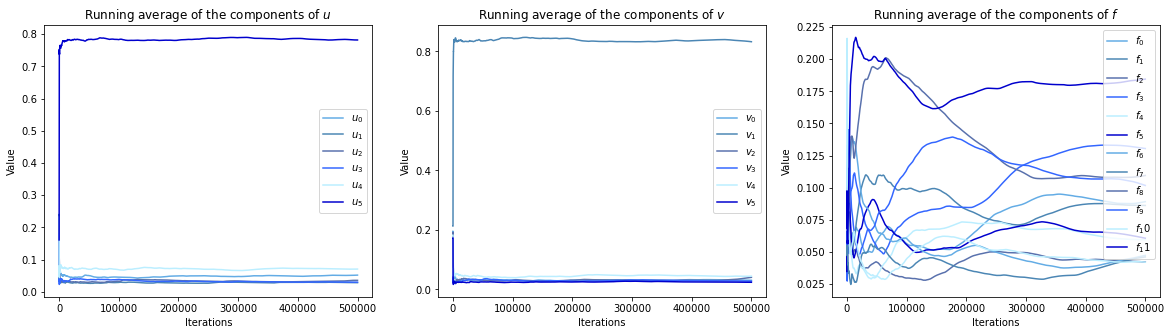

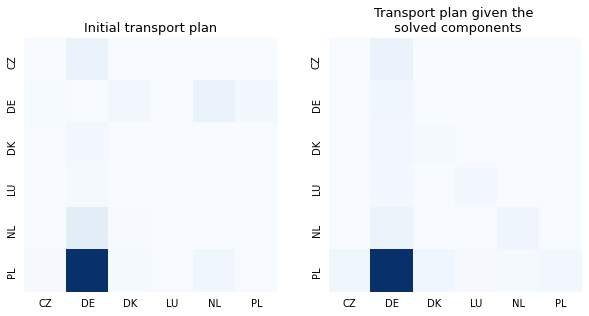

In [368]:
plot_inverse_transport_f(path_mig_f1,accep_mig_f1,(u_av_f1,v_av_f1,W_av_f1),
                           convergence=True,
                           labels=countries,
                           transport=(True,tmap_mig))

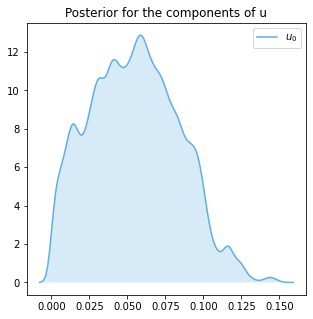

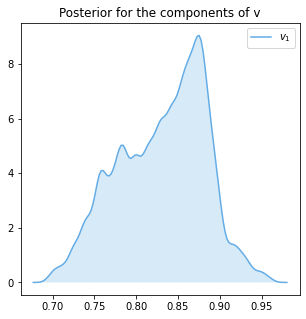

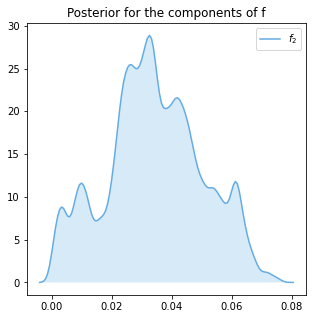

In [397]:
plot_posteriors_f({0:[0],1:[1],2:[2]},path_mig_f1)

### 3.2.2 Implementation of RwM with graph-based cost with the diagonal adjusted

In [392]:
######### these ones done with cost of diag high
path_mig_f2,accep_mig_f2 = rand_walk_metrop_f(sigma_mig,tmap_mig,variance_mig,n=500000,exact=False,
                                                memory=True,f_init=f_init)

0_ 
10000_ 
20000_ 
30000_ 
40000_ 
50000_ 
60000_ 
70000_ 
80000_ 
90000_ 
100000_ 
110000_ 
120000_ 
130000_ 
140000_ 
150000_ 
160000_ 
170000_ 
180000_ 
190000_ 
200000_ 
210000_ 
220000_ 
230000_ 
240000_ 
250000_ 
260000_ 
270000_ 
280000_ 
290000_ 
300000_ 
310000_ 
320000_ 
330000_ 
340000_ 
350000_ 
360000_ 
370000_ 
380000_ 
390000_ 
400000_ 
410000_ 
420000_ 
430000_ 
440000_ 
450000_ 
460000_ 
470000_ 
480000_ 
490000_ 


In [393]:
u_av_f2,v_av_f2,W_av_f2 = running_average(path_mig_f2)

/Users/anyafries/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


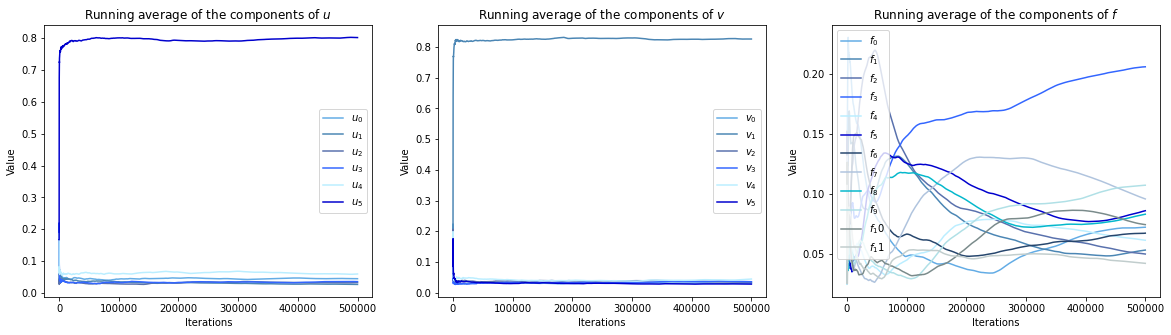

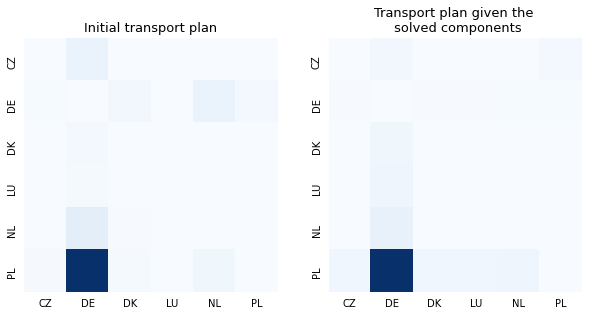

In [394]:
plot_inverse_transport_f(path_mig_f2,accep_mig_f2,(u_av_f2,v_av_f2,W_av_f2),
                           convergence=True,
                           labels=countries,
                           transport=(True,tmap_mig))

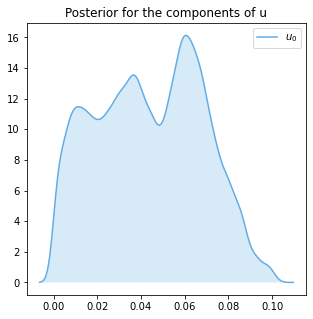

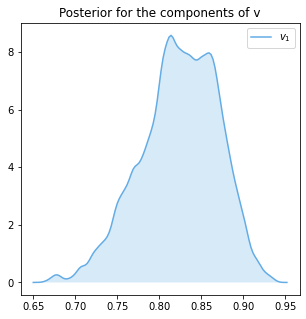

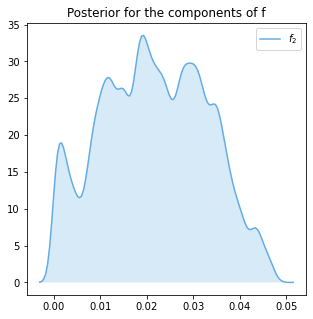

In [395]:
plot_posteriors_f({0:[0],1:[1],2:[2]},path_mig_f2)

We see very little difference between adjusting the diagonal and not, and between graph-based cost and the general cost matrix.

# 4. Simulated annealing

We implement simulated annealing while staying with the general cost matrix to maintain full generality of the algorithm.

The algorithm remains the same except that we have a decreasing temperature parameter that depends on the iteration instead of `sigma`. This is given by a function `temp_scheme`.

In [134]:
def norm_diff(X,T,exact=False):
    a,b,W = X
    if exact: plan = ot.emd(a, b, W/np.sum(W))
    else: plan,cost,iters = sinkhorn(0.04,a/np.sum(a),b/np.sum(b),C=W/np.sum(W))
    return (np.linalg.norm(T - plan))**2

In [174]:
def simulated_annealing(T,variance,temp_scheme,n=1000,
                        map_diff=False,
                        exact=False,
                        W_init=None,
                        print_indexes=True):
    """ Perform RwM until convergence
        Input: T           - the given transport plan
               variance    - given as [v1,v2,v3] the variance of the steps taken for u,v,W during RwM 
               temp_scheme - temperature function to be used, a function of n/the index
               n           - how many runs to perfom
               map_diff    - keep track of the normed diff between the current plan and the original map 
               exact       - a Boolean, solve with exact transport plan (otherwise Sinkhorn)
               W_init      - optional starting value for W 
               print_indexes - optional, to show how far the algorithm is"""
    
    # initialise u,v,f as uniform
    u,v = np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1)),np.array([1/len(T) for _ in range(len(T))]).reshape((len(T),1))
    if W_init is None: W = np.array([[1/len(T)**2 for _ in range(len(T))] for _ in range(len(T))])
    else: W = W_init
    
    # random walk
    order = [0,1,2]
    path = []
    diffs = []
    best_diff = [float('inf')]
    accep_rates = [0,0,0]
    for index in range(n):
        if print_indexes: 
            if index%10000==0:print(str(index)+"_ ")
        rand.shuffle(order) # randomise choice of component to change
        for i in order:
            temp = temp_scheme(i)
            a,(u,v,W) = walk(temp,T,i,[u,v,W],variance) 
            accep_rates[i] += a
        if map_diff: 
            diff = norm_diff((u,v,W),T)
            if diff < best_diff[-1]: best_diff.append(diff)
            else: best_diff.append(best_diff[-1])
            diffs.append(diff)
        path.append((u/np.sum(u),v/np.sum(v),W/np.sum(W)))
    if map_diff: return best_diff[1:],diffs,path,np.divide(accep_rates,n)
    else: return path,np.divide(accep_rates,n)

#### Different choices for the temperature scheme

In [365]:
# log decrease
def T_log(a):
    assert(a>0)
    def T(i):
        if i==0: return 3*a/np.log(2)
        if i==1: return 2*a/np.log(2)
        return a/np.log(i)
    return T

# polynomial decrease
def T_polynomial(a, b):
    assert(a>0 and b<0)
    def T(i):
        return a*((i+1)**b)
    return T

# exponential decrease
def T_exponential(a, b):
    assert(a>0 and 0<b<1)
    def T(i):
        return a*(b**i)
    return T

# cosine walk
def T_cosine(a,b):
    def T(i):
        return a*np.cos(i/b) + a
    return T

# linear reheat
def T_linear_reheat(a,b):
    def T(i):
        r = n//b
        index = min(9,i//b)
        if index==0: j = i
        else: 
            j = i - (i//b)*b
        return (a/2**(i//b))*(1-j/b)
    return T

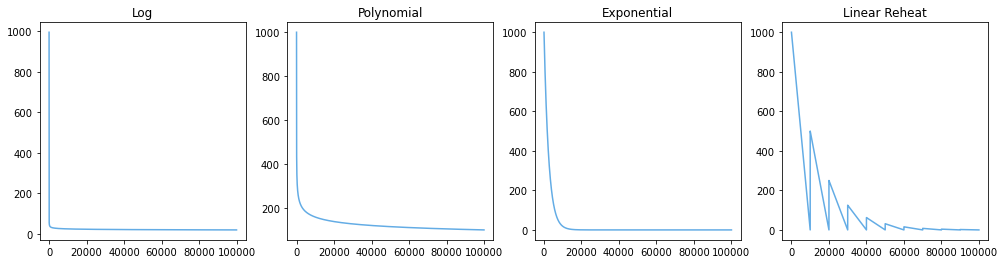

In [366]:
n = 100000
temp_schemes = [T_log(230),T_polynomial(1000,-0.2),T_exponential(1000,0.9996),T_linear_reheat(1000,10000)]
names = ["Log","Polynomial","Exponential","Linear Reheat"]
i = 1

plt.figure(figsize=(17,4))
plt.subplots_adjust(hspace=0.3)

for T in temp_schemes:
    plt.subplot(1,4,i)
    plt.plot([T(i) for i in range(n)])
    plt.title(names[i-1])    
    i+=1

plt.show()

## 4.1 Plots for simulated annealing

In [367]:
def plot_sim_ann_map_diff(T,title,t_map,variance,iters=10000,cost_init=None,print_indexes=False,f=False):
    if f:
        best_diffs,map_diffs,path,accep_rate = simulated_annealing_f(t_map,variance,T,n=iters,exact=False,
                                                                print_indexes=print_indexes,
                                                                f_init=cost_init,
                                                                map_diff=True)
    else:
        best_diffs,map_diffs,path,accep_rate = simulated_annealing(t_map,variance,T,n=iters,exact=False,
                                                                print_indexes=print_indexes,
                                                                W_init=cost_init,
                                                                map_diff=True)
    plt.plot(map_diffs,label="Running")
    plt.plot(best_diffs,label="Best",color='darkblue')
    plt.title(title)
    return map_diffs,path

def plot_sim_ann_components(path):
    # we plot the first entry of u,v,W
    plt.figure(figsize=(10,4))
    u,v,W=[],[],[]
    for i in range(len(path)):
        u.append(path[i][0][0])
        v.append(path[i][1][0])
        W.append(path[i][2][0][0])
    plt.plot(u, label="$u_0$", color='mediumblue')
    plt.plot(v, label="$v_0$",color='lightblue')
    plt.plot(W, label="$W_{0,0}$",color='#4b86b4')
    plt.title("Running value of the first entry of $u,v,W$")
    plt.show()

### 4.1.1 Difference in norm between original transport map and transport map given the solved components for different temperature schemes/parameters/graph constraints

#### Log temperature, general cost, 400000 iterations

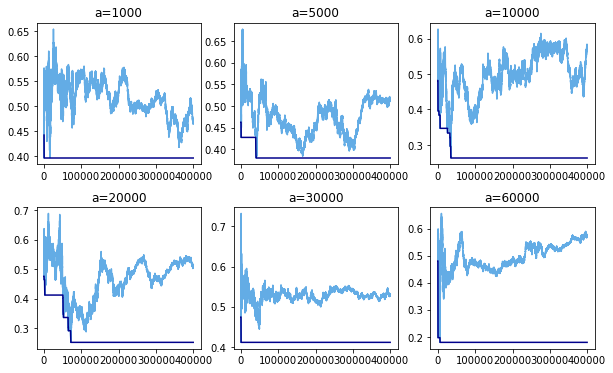

In [183]:
# General cost matrix
# Log temperature
plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [1000, 5000, 10000, 20000, 30000, 60000]:
    T = T_log(a)
    title = "a={}".format(a)
    plt.subplot(2,3,i)
    map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=400000,
                                   cost_init=cost_init_mig)
    i+=1
plt.show()

#### Cos temperature, general cost, 200000 iterations

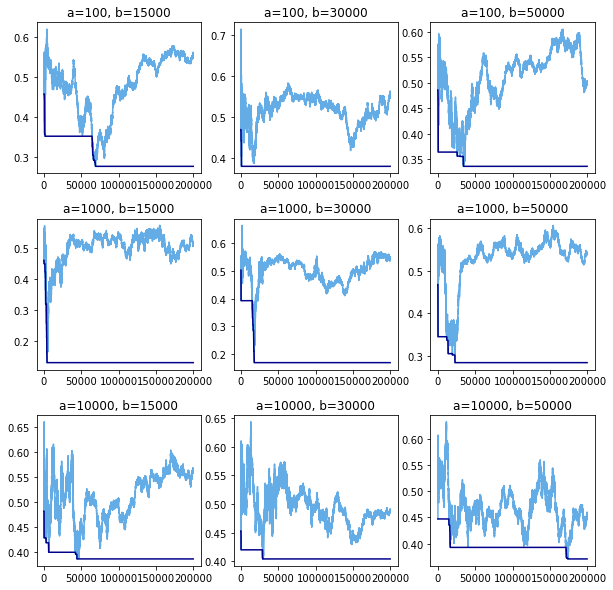

In [377]:
# Cos temperature
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
diffs_cos = []
paths_cos = []

n = 200000
for a in [100, 1000, 10000]:
    for b in [15000, 30000, 50000]:
        T = T_cosine(a,b)
        title = "a={}, b={}".format(a,b)
        plt.subplot(3,3,i)
        map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=n,
                                       cost_init=cost_init_mig)
        diffs_cos.append(map_diffs)
        paths_cos.append(path)
        i+=1
plt.show()

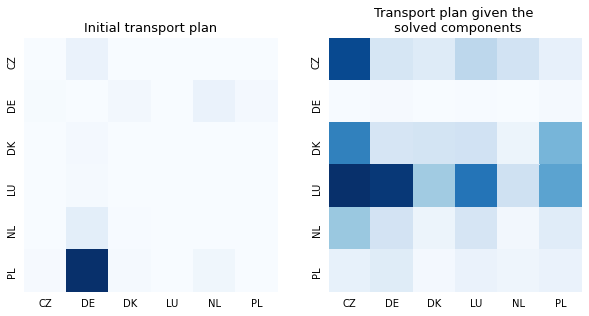

In [379]:
index_cos = diffs_cos[4].index(diffs_cos[4][-1])
u_cos,v_cos,W_cos = paths_cos[4][index_cos]

plan_cos,cost_cos,iters_cos = sinkhorn(0.04,u_cos,v_cos,C=W_cos)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1) # first heatmap
ax = sns.heatmap(tmap_mig,cbar=False,cmap="Blues",square= True) #Blues,Greys
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(countries)
ax.set_yticklabels(countries)
ax.set_title("Initial transport plan",fontsize=13)

plt.subplot(1,2,2) # second heatmap
ax = sns.heatmap(plan_cos,cbar=False,cmap="Blues",square= True) 
ax.tick_params(left=False,bottom=False) 
ax.set_xticklabels(countries)
ax.set_yticklabels(countries)
ax.set_title("Transport plan given the \n solved components",fontsize=13)

plt.show()   

#### Linear reheat temperate, general cost, 300000 iterations

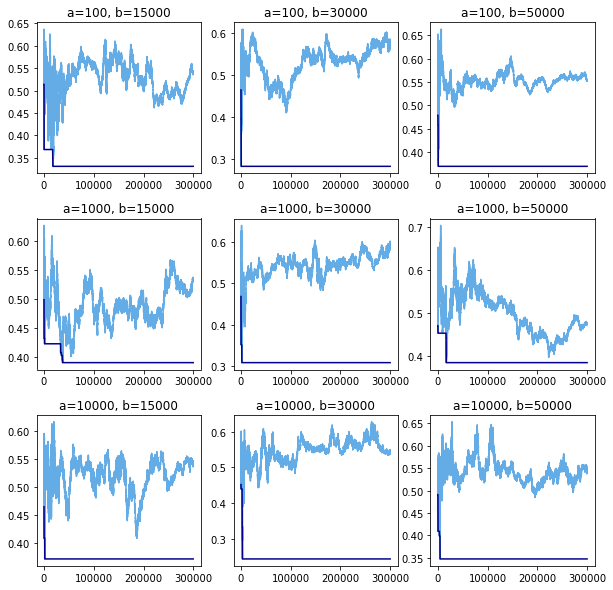

In [364]:
# Linear reheat temperature
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
diffs_lreheat = []
paths_lreheat = []

n = 300000
for a in [100, 1000, 10000]:
    for b in [15000, 30000, 50000]:
        T = T_linear_reheat(a,b)
        title = "a={}, b={}".format(a,b)
        plt.subplot(3,3,i)
        map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=n,
                                       cost_init=cost_init_mig)
        diffs_lreheat.append(map_diffs)
        paths_lreheat.append(path)
        i+=1
plt.show()

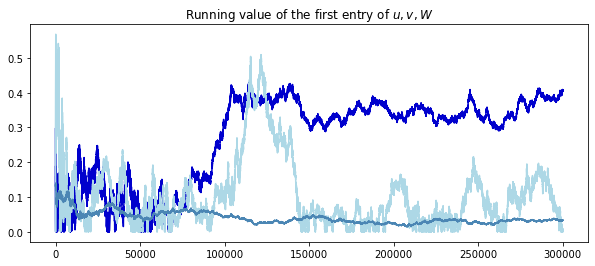

In [376]:
plot_sim_ann_components(paths_lreheat[7])

#### Polynomial temperature, general cost, 100000 iterations

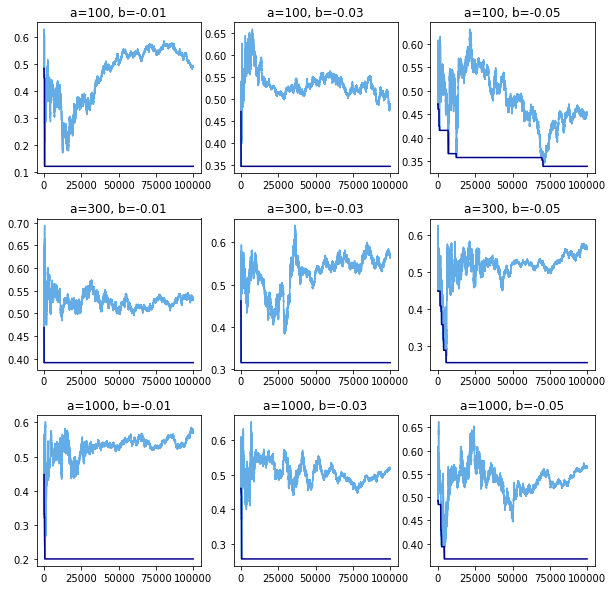

In [166]:
# General cost matrix
# Polynomial temperature
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [100, 300, 1000]: # to rerun !!! TO DO
    for b in [-0.25, -0.3, -0.5]:
        T = T_polynomial(a, b)
        title = "a={}, b={}".format(a,b)
        plt.subplot(3,3,i)
        map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=100000,
                                       cost_init=cost_init_mig)
        i+=1
plt.show()

#### Polynomial temperature, general cost, 500000 iterations

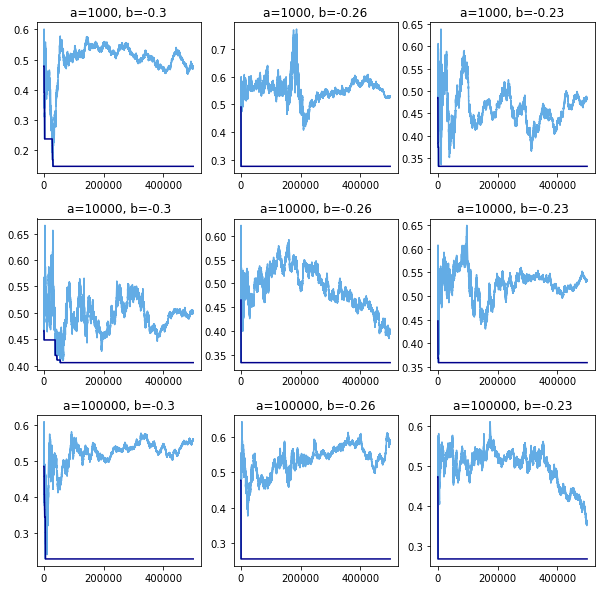

In [380]:
# Graph based cost
# Log temperature
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
diffs_poy = []
paths_poy = []
for a in [1000, 10000, 100000]: ## VALUES CHOSEN SO THAT THEY TEND TO 0 OVER [0,400000]
    for b in [-0.3, -0.26, -0.23]:
        T = T_polynomial(a, b)
        title = "a={}, b={}".format(a,b)
        plt.subplot(3,3,i)
        map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=500000,
                                       cost_init=f_init, f=True)
        diffs_poy.append(map_diffs)
        paths_poy.append(path)
        i+=1
plt.show()

#### Exponential temperature, general cost, 100000 iterations

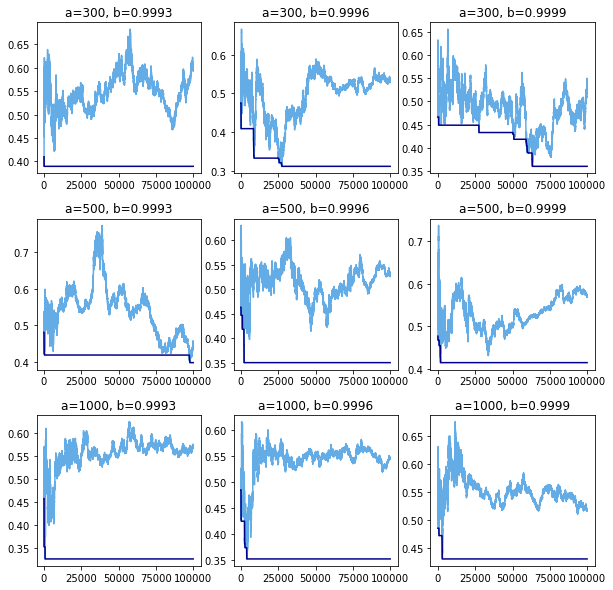

In [167]:
# General cost matrix
# Exponential temperature
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
i = 1
for a in [300, 500, 1000]:
    for b in [0.9993, 0.9996, 0.9999]:
        T = T_exponential(a, b)
        title = "a={}, b={}".format(a,b)
        plt.subplot(3,3,i)
        map_diffs,path = plot_sim_ann_map_diff(T,title,tmap_mig,variance_mig,iters=100000,
                                       cost_init=cost_init_mig)
        i+=1
plt.show()